# Google Gemini Test
Testing Google's Gemini on rating Yelp reviews.

In [1]:
import os
import itertools
import json
import pandas as pd
import seaborn as sns
import time

from dotenv import load_dotenv
import google.generativeai as genai
from tqdm import tqdm

_ = load_dotenv()

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key = GOOGLE_API_KEY)

model = genai.GenerativeModel("gemini-pro")

Here we use only the first 2000 lines of data to limit the amount of time needed for Gemini to process all the reviews.

In [3]:
# Load the data
N = 2000 # Limit the number of requests to the LLM
df = pd.read_csv("yelp_review.csv")[:N]
df

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...,...
1995,1995,CDShGHA0UPSedh18S5K3eg,2N_gW_rtIoVzifhgdRX9og,-ikBycdroyTLDBHR9aC3HA,4.0,1,0,0,"I eat at Sukho Thai quite a bit, and I don't r...",2011-09-25 22:30:48
1996,1996,x-OF89Y84uXvSRbeIskdfQ,zPxvMIlv0W0HgTlMoU-WaQ,Zi-F-YvyVOK0k5QD7lrLOg,5.0,6,2,3,"When you dine at Muriel's, check to see if the...",2015-05-26 07:29:36
1997,1997,1V0bzX70ZuP7KJXIJ1dLMQ,mIyOekSeriEs7kZ9UHGF6Q,OHzX-ZD9qyoeoxR8Z0dlIA,5.0,0,0,1,Had a wonderful lunch of fried green tomatoes ...,2014-07-28 00:27:44
1998,1998,fE2DRDTFrCFa47tqeYmXlQ,wfi0T-xq_P5sKQvwQitlYg,jgUJ2CkM3LaRHpt3JhKc7g,3.0,0,0,1,I like to make a stop at this Walmart since it...,2013-01-27 22:49:11


We disable these "safety settings" so we don't get any errors later. Safety is not a big concern.

In [4]:
def query_model(query: str) -> str:
    """Query the model, ignoring safety settings. Does not sanitize/check input."""
    response = model.generate_content(
        query,
        safety_settings = [
            {
              "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
              "threshold": "BLOCK_NONE",
            },
            {
              "category": "HARM_CATEGORY_HATE_SPEECH",
              "threshold": "BLOCK_NONE",
            },
            {
              "category": "HARM_CATEGORY_HARASSMENT",
              "threshold": "BLOCK_NONE",
            },
            {
              "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
              "threshold": "BLOCK_NONE",
            }
        ]
    )
    return response.text

We specify the prompt here. The prompt can be improved further in order to limit the responses to 'Positive', 'Negative', and 'Neutral.' This prompt happens to also give us the words 'Mixed' and 'Average.'

In [5]:
def process_review(review: str) -> str:
    """Classify a review as 'Positive', 'Negative', or 'Neutral'"""
    result = query_model(
        "Given the following review enclosed in triple backticks, rate the review as Positive, Negative, or Neutral\n"
        "Answer in only one word.\n"
        f"```{review}```"
    )

    # Arbitrary sleep time to not trigger rate-limiting
    time.sleep(0.5)
    
    return result

This cell can take an hour or so to run.

In [6]:
# d_cls = []
# for res in tqdm(map(process_review, df["text"]))
df["sentiment"] = pd.DataFrame(tqdm(map(process_review, df["text"]), total = df.shape[0], ncols = 120))
# df["sentiment"] = d_cls
df

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [56:32<00:00,  1.70s/it]


,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Negative
1,1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Positive
2,2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Positive
3,3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Positive
4,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Positive
...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,CDShGHA0UPSedh18S5K3eg,2N_gW_rtIoVzifhgdRX9og,-ikBycdroyTLDBHR9aC3HA,4.0,1,0,0,"I eat at Sukho Thai quite a bit, and I don't r...",2011-09-25 22:30:48,Positive
1996,1996,x-OF89Y84uXvSRbeIskdfQ,zPxvMIlv0W0HgTlMoU-WaQ,Zi-F-YvyVOK0k5QD7lrLOg,5.0,6,2,3,"When you dine at Muriel's, check to see if the...",2015-05-26 07:29:36,Positive
1997,1997,1V0bzX70ZuP7KJXIJ1dLMQ,mIyOekSeriEs7kZ9UHGF6Q,OHzX-ZD9qyoeoxR8Z0dlIA,5.0,0,0,1,Had a wonderful lunch of fried green tomatoes ...,2014-07-28 00:27:44,Positive
1998,1998,fE2DRDTFrCFa47tqeYmXlQ,wfi0T-xq_P5sKQvwQitlYg,jgUJ2CkM3LaRHpt3JhKc7g,3.0,0,0,1,I like to make a stop at this Walmart since it...,2013-01-27 22:49:11,Neutral


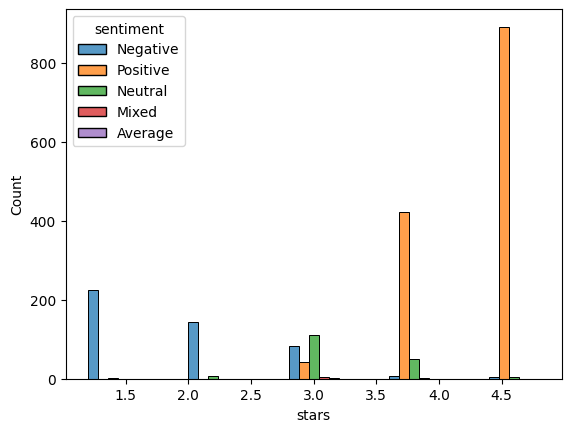

In [7]:
_ = sns.histplot(df, x = "stars", hue = "sentiment", multiple = "dodge", bins = 5, shrink = 0.5)